# Contrastive Learning with SimCLR (Score: 150)

---

FULLNAME: Zahra Fallah Mirmousavi

STUDENT NUMBER: 401207192

In [1]:
import os
from copy import deepcopy
import random


import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import seaborn as sns
import numpy as np

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Use as many workers as possible in a data loader
NUM_WORKERS = os.cpu_count()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Random seed set as 42
Device: cuda:0
Number of workers: 2


<Figure size 640x480 with 0 Axes>

## Data Augmentation for Contrastive Learning

To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice.

In [2]:
class ContrastiveTransformations:
    """
    Take two random crops of one image, and apply a set of
    augmentations.
    """
    def __init__(self, base_transforms, n_views=2):
        self.base_transformt = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transformt(x) for i in range(self.n_views)]
        return views

The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR since it directly affects how the latent space is structured, and what patterns might be learned from the data.

**-- TO DO (20) --**

for our experiments, we apply a set of 5 transformations following the original SimCLR setup: random horizontal flip, crop-and-resize (size=96), color distortion (brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1), random grayscale, and gaussian blur (kerenel_size=9). In comparison to the original implementation, we reduce the effect of the color jitter slightly (0.5 instead of 0.8 for brightness, contrast, and saturation, and 0.1 instead of 0.2 for hue).

In [3]:
import torchvision.transforms as transforms

contrast_transforms = transforms.Compose([
    ####################################
    ##              To Do             ##
    ####################################
    # Random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Random crop-and-resize with target size 96x96
    transforms.RandomResizedCrop(size=96),

    # Color distortion with specified brightness, contrast, saturation, and hue
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),

    # Random grayscale with a probability of 0.2
    transforms.RandomGrayscale(p=0.2),

    # Gaussian blur with kernel size 9
    transforms.GaussianBlur(kernel_size=9),

    ####################################
    ####################################
    # Convert to tensor
    transforms.ToTensor(),

    # Normalize to [-1, 1] range with mean and std for RGB images
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


## Dataset

In this homework, we will use the STL10 dataset, which, similarly to CIFAR10, contains images of 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck. However, the images have a higher resolution, namely $96\times 96$
 pixels, and we are only provided with 500 labeled images per class. Additionally, we have a much larger set of 100,000
 unlabeled images which are similar to the training images but are sampled from a wider range of animals and vehicles. This makes the dataset ideal to showcase the benefits that self-supervised learning offers.

In [4]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True, transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True, transform=ContrastiveTransformations(contrast_transforms, n_views=2))

100%|██████████| 2.64G/2.64G [01:48<00:00, 24.3MB/s]


Extracting ../data/stl10_binary.tar.gz to ../data
Files already downloaded and verified


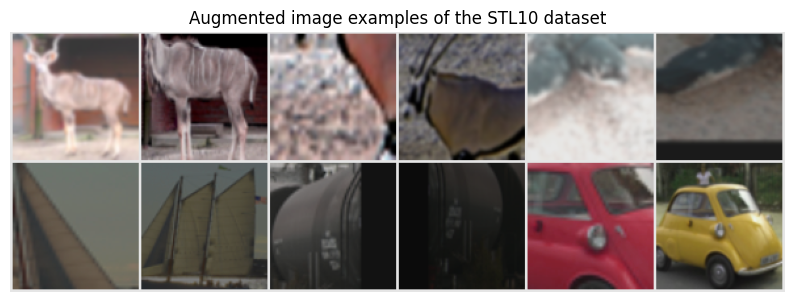

In [5]:
# Visualize some examples
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## SimCLR Implementation

In [6]:
class SimCLR(nn.Module):

    def __init__(self, hidden_dim, output_dim):
        super().__init__()

        # Base mdoel f(.)
        self.f = torchvision.models.resnet18(num_classes=hidden_dim, pretrained=False)

        # Projection head g(.)
        self.g = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=output_dim)
        )

    def forward(self, x):
        return self.g(self.f(x))

### InfoNCE loss

InfoNCE, where NCE stands for Noise-Contrastive Estimation, is a type of contrastive loss function used for self-supervised learning.


$l_{ij}=log(\frac{exp(sim(z_i, z_j)/\tau)}{\sum_{k=1}^{2N}𝟙_{k\neq i}exp(sim(z_i, z_k)/\tau)}) $

$sim(z_i, z_j) = \frac{z_i^T.z_j}{\|z_i\|.\|z_j\|}$

Using this loss we want to maximize the similarity between the representations of the two augmented versions of the same image, while minimizing it to all other examples in the batch.

**TODO: Implement this loss function in cell below: (50)**

In [7]:
import torch
import torch.nn.functional as F

def info_nce_loss(features_1, features_2, temperature=0.5):
    """
    InfoNCE Loss implementation based on the given formula.

    Args:
        features_1: (batch_size, hidden_dim) tensor containing features from first series of augmentations.
        features_2: (batch_size, hidden_dim) tensor containing features from second series of augmentations.
        temperature: scaling factor to control the sharpness of the similarity distribution.

    Returns:
        Scalar InfoNCE loss.
    """
    # Normalize the feature vectors to unit length
    features_1 = F.normalize(features_1, dim=-1)
    features_2 = F.normalize(features_2, dim=-1)

    # Compute cosine similarity matrix between all pairs
    similarity_matrix = torch.matmul(features_1, features_2.T)  # (batch_size, batch_size)

    # Scale by temperature
    similarity_matrix /= temperature

    # Create labels (diagonal elements of the similarity matrix)
    labels = torch.arange(features_1.size(0)).to(features_1.device)

    # Compute the numerator (exp(similarity) for the correct pair i, j)
    numerator = torch.exp(similarity_matrix[labels, labels])

    # Compute the denominator (sum of exp(similarity) over all pairs except for the correct pair)
    denominator = torch.sum(torch.exp(similarity_matrix), dim=-1)

    # InfoNCE loss is the negative log of the ratio
    loss = -torch.log(numerator / denominator).mean()

    return loss


### Training SimCLR

**TODO: Implement the training and evaluation loops for the SimCLR model: (20)**

In [8]:
from tqdm.notebook import tqdm
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# Create dataloaders
train_loader = DataLoader(unlabeled_data, batch_size=1024, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(train_data_contrast, batch_size=1024, shuffle=False, num_workers=NUM_WORKERS)

# Initialize the model
simclr_model = SimCLR(hidden_dim=512, output_dim=128).to(device)
optimizer = optim.Adam(simclr_model.parameters(), lr=5e-4, weight_decay=1e-4)

# Training loop
n_epochs = 5
temperature = 0.07


# checkpoint_path = "simclr_model_epoch_5.pth"  # Replace with your saved file path
# simclr_model.load_state_dict(torch.load(checkpoint_path))


for epoch in range(n_epochs):
    simclr_model.train()  # Set model to training mode
    epoch_loss = 0

    # Loop through the batches of data for training
    for (x) in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}"):
        # x[0] is a list of two 4D tensors (views of data)
        # x[1] is the label tensor (which we don't need here)

        # Unpack x[0] into two 4D tensors (view1 and view2)
        view1, view2 = x[0]

        # Move both tensors to the device
        view1 = view1.to(device)
        view2 = view2.to(device)

        # Forward pass: Compute features for both views
        features_1 = simclr_model(view1)  # Features for the first view
        features_2 = simclr_model(view2)  # Features for the second view

        # Compute the InfoNCE loss
        loss = info_nce_loss(features_1, features_2, temperature)
        epoch_loss += loss.item()

        # Backward pass: Compute gradients and update model parameters
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update model parameters

    # Print the average loss for this epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}")

    # Validation step
    simclr_model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for (x) in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{n_epochs}"):
            # Unpack x[0] into two 4D tensors (view1 and view2)
            view1, view2 = x[0]

            # Move both tensors to the device
            view1 = view1.to(device)
            view2 = view2.to(device)

            # Forward pass: Compute features for both views
            features_1 = simclr_model(view1)  # Features for the first view
            features_2 = simclr_model(view2)  # Features for the second view

            # Compute the InfoNCE loss
            loss = info_nce_loss(features_1, features_2, temperature)
            val_loss += loss.item()

    # Print the average validation loss for this epoch
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Optionally, save the model checkpoint after each epoch
    torch.save(simclr_model.state_dict(), f"simclr_model_epoch_{epoch + 1}.pth")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch [1/5], Loss: 5.6326


Validation Epoch 1/5:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 5.0005


Epoch 2/5:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch [2/5], Loss: 4.0628


Validation Epoch 2/5:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 3.7782


Epoch 3/5:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch [3/5], Loss: 3.1274


Validation Epoch 3/5:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 2.9625


Epoch 4/5:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch [4/5], Loss: 2.7000


Validation Epoch 4/5:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 2.7568


Epoch 5/5:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch [5/5], Loss: 2.4415


Validation Epoch 5/5:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 2.4061


# Classification using logistic regression

In [9]:
class LogisticRegression(nn.Module):

    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

The data we use is the training and test set of STL10. The training contains 500 images per class, while the test set has 800 images per class.

In [10]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 5000
Number of test examples: 8000


**TODO: Use the f layer of the SimCLR model to extract features from the train and test datasets: (20)**

In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset

@torch.no_grad()
def prepare_data_features(model, dataset):
    """
    Extract features using the f layer of the SimCLR model.

    Args:
        model: The SimCLR model (expects model.f to be the feature extractor).
        dataset: The dataset from which features are extracted (expects a PyTorch dataset).
        batch_size: Batch size for processing data.
        device: Device to run the computation ('cuda' or 'cpu').

    Returns:
        TensorDataset containing the extracted features and their corresponding labels.
    """
    batch_size=1024
    # Prepare a DataLoader for the dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Switch model to evaluation mode
    model.eval()

    # Move the model to the specified device
    model = model.to(device)

    # Initialize lists to store features and labels
    all_feats = []
    all_labels = []

    # Iterate through the dataset
    for images, labels in dataloader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Extract features using the f layer of the model
        feats = model.f(images)  # Assuming model.f is the feature extractor

        # Append features and labels to the lists
        all_feats.append(feats.cpu())
        all_labels.append(labels.cpu())

    # Concatenate all features and labels
    all_feats = torch.cat(all_feats, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Return the features and labels as a TensorDataset
    return TensorDataset(all_feats, all_labels)


In [12]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

In [13]:
# Data loaders
train_loader = DataLoader(train_feats_simclr, batch_size=512, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_feats_simclr, batch_size=512, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

**TODO: Implement the training and evaluation loops for the LogisticRegression
model: (20)**

In [14]:
from tqdm.notebook import tqdm

# Initialize the model
model = LogisticRegression(feature_dim=512, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

# Training loop
n_epochs = 100

for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0
    correct = 0
    total = 0

    # Loop over the training data
    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}"):
        features, labels = features.to(device), labels.to(device)

        # Forward pass: Get model predictions
        predictions = model(features)

        # Compute the loss (cross-entropy for classification)
        loss = F.cross_entropy(predictions, labels)
        epoch_loss += loss.item()

        # Backward pass: Compute gradients and update model parameters
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update model parameters

        # Compute accuracy
        _, predicted = predictions.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print the loss and accuracy for this epoch
    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


    # Validation step
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for features, labels in tqdm(test_loader, desc=f"Validation Epoch {epoch + 1}/{n_epochs}"):
            features, labels = features.to(device), labels.to(device)

            # Forward pass: Get model predictions
            predictions = model(features)

            # Compute the loss (cross-entropy for classification)
            loss = F.cross_entropy(predictions, labels)
            val_loss += loss.item()

            # Compute accuracy
            _, predicted = predictions.max(1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Print the validation loss and accuracy for this epoch
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f"Test Loss: {avg_val_loss:.4f}, Test Accuracy: {val_accuracy:.2f}%")


Epoch 1/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/100], Loss: 2.2613, Accuracy: 17.00%


Validation Epoch 1/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.9690, Test Accuracy: 26.14%


Epoch 2/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [2/100], Loss: 1.8287, Accuracy: 34.42%


Validation Epoch 2/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.7010, Test Accuracy: 40.42%


Epoch 3/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [3/100], Loss: 1.6183, Accuracy: 43.54%


Validation Epoch 3/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.5474, Test Accuracy: 46.55%


Epoch 4/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [4/100], Loss: 1.4939, Accuracy: 48.76%


Validation Epoch 4/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.4649, Test Accuracy: 49.21%


Epoch 5/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5/100], Loss: 1.4168, Accuracy: 51.48%


Validation Epoch 5/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.4105, Test Accuracy: 50.15%


Epoch 6/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [6/100], Loss: 1.3639, Accuracy: 52.48%


Validation Epoch 6/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.3641, Test Accuracy: 51.42%


Epoch 7/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [7/100], Loss: 1.3234, Accuracy: 53.44%


Validation Epoch 7/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.3384, Test Accuracy: 52.49%


Epoch 8/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [8/100], Loss: 1.2914, Accuracy: 54.38%


Validation Epoch 8/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.3091, Test Accuracy: 53.75%


Epoch 9/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [9/100], Loss: 1.2660, Accuracy: 55.42%


Validation Epoch 9/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.2876, Test Accuracy: 53.77%


Epoch 10/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.2449, Accuracy: 56.06%


Validation Epoch 10/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.2740, Test Accuracy: 53.92%


Epoch 11/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [11/100], Loss: 1.2288, Accuracy: 56.32%


Validation Epoch 11/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.2598, Test Accuracy: 54.85%


Epoch 12/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [12/100], Loss: 1.2159, Accuracy: 56.60%


Validation Epoch 12/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.2513, Test Accuracy: 54.95%


Epoch 13/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [13/100], Loss: 1.2059, Accuracy: 56.86%


Validation Epoch 13/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.2427, Test Accuracy: 54.59%


Epoch 14/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [14/100], Loss: 1.2025, Accuracy: 56.38%


Validation Epoch 14/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.2410, Test Accuracy: 55.36%


Epoch 15/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15/100], Loss: 1.1861, Accuracy: 57.26%


Validation Epoch 15/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.2243, Test Accuracy: 55.90%


Epoch 16/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [16/100], Loss: 1.1822, Accuracy: 57.44%


Validation Epoch 16/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.2143, Test Accuracy: 56.26%


Epoch 17/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [17/100], Loss: 1.1639, Accuracy: 58.32%


Validation Epoch 17/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.2132, Test Accuracy: 56.02%


Epoch 18/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [18/100], Loss: 1.1563, Accuracy: 58.36%


Validation Epoch 18/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.2013, Test Accuracy: 56.16%


Epoch 19/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [19/100], Loss: 1.1508, Accuracy: 58.70%


Validation Epoch 19/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.2057, Test Accuracy: 55.80%


Epoch 20/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20/100], Loss: 1.1452, Accuracy: 58.90%


Validation Epoch 20/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1948, Test Accuracy: 56.20%


Epoch 21/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [21/100], Loss: 1.1382, Accuracy: 58.64%


Validation Epoch 21/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1996, Test Accuracy: 56.24%


Epoch 22/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [22/100], Loss: 1.1333, Accuracy: 58.98%


Validation Epoch 22/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1856, Test Accuracy: 56.79%


Epoch 23/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [23/100], Loss: 1.1310, Accuracy: 58.74%


Validation Epoch 23/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1820, Test Accuracy: 56.99%


Epoch 24/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [24/100], Loss: 1.1223, Accuracy: 58.72%


Validation Epoch 24/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1796, Test Accuracy: 57.10%


Epoch 25/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25/100], Loss: 1.1173, Accuracy: 59.48%


Validation Epoch 25/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1765, Test Accuracy: 57.01%


Epoch 26/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [26/100], Loss: 1.1173, Accuracy: 59.34%


Validation Epoch 26/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1750, Test Accuracy: 57.29%


Epoch 27/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [27/100], Loss: 1.1172, Accuracy: 59.06%


Validation Epoch 27/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1796, Test Accuracy: 56.54%


Epoch 28/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [28/100], Loss: 1.1188, Accuracy: 58.88%


Validation Epoch 28/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1729, Test Accuracy: 56.76%


Epoch 29/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [29/100], Loss: 1.1151, Accuracy: 59.30%


Validation Epoch 29/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1768, Test Accuracy: 57.20%


Epoch 30/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [30/100], Loss: 1.1113, Accuracy: 59.18%


Validation Epoch 30/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1712, Test Accuracy: 57.04%


Epoch 31/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [31/100], Loss: 1.1017, Accuracy: 59.44%


Validation Epoch 31/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1686, Test Accuracy: 57.26%


Epoch 32/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [32/100], Loss: 1.1019, Accuracy: 59.62%


Validation Epoch 32/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1639, Test Accuracy: 57.12%


Epoch 33/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [33/100], Loss: 1.0953, Accuracy: 59.78%


Validation Epoch 33/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1782, Test Accuracy: 56.34%


Epoch 34/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [34/100], Loss: 1.0978, Accuracy: 59.70%


Validation Epoch 34/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1654, Test Accuracy: 57.30%


Epoch 35/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [35/100], Loss: 1.0918, Accuracy: 60.14%


Validation Epoch 35/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1606, Test Accuracy: 57.59%


Epoch 36/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [36/100], Loss: 1.0911, Accuracy: 60.18%


Validation Epoch 36/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1595, Test Accuracy: 57.95%


Epoch 37/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [37/100], Loss: 1.0852, Accuracy: 60.34%


Validation Epoch 37/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1575, Test Accuracy: 58.00%


Epoch 38/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [38/100], Loss: 1.0862, Accuracy: 60.20%


Validation Epoch 38/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1576, Test Accuracy: 57.94%


Epoch 39/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [39/100], Loss: 1.0816, Accuracy: 60.54%


Validation Epoch 39/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1517, Test Accuracy: 57.99%


Epoch 40/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [40/100], Loss: 1.0832, Accuracy: 60.60%


Validation Epoch 40/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1515, Test Accuracy: 57.96%


Epoch 41/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [41/100], Loss: 1.0795, Accuracy: 60.30%


Validation Epoch 41/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1505, Test Accuracy: 57.88%


Epoch 42/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [42/100], Loss: 1.0780, Accuracy: 60.98%


Validation Epoch 42/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1528, Test Accuracy: 57.54%


Epoch 43/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [43/100], Loss: 1.0782, Accuracy: 60.16%


Validation Epoch 43/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1496, Test Accuracy: 57.90%


Epoch 44/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [44/100], Loss: 1.0784, Accuracy: 60.46%


Validation Epoch 44/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1525, Test Accuracy: 57.90%


Epoch 45/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [45/100], Loss: 1.0741, Accuracy: 60.70%


Validation Epoch 45/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1449, Test Accuracy: 58.14%


Epoch 46/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [46/100], Loss: 1.0719, Accuracy: 60.62%


Validation Epoch 46/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1506, Test Accuracy: 57.84%


Epoch 47/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [47/100], Loss: 1.0711, Accuracy: 60.46%


Validation Epoch 47/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1414, Test Accuracy: 58.74%


Epoch 48/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [48/100], Loss: 1.0686, Accuracy: 60.94%


Validation Epoch 48/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1440, Test Accuracy: 58.10%


Epoch 49/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [49/100], Loss: 1.0673, Accuracy: 61.02%


Validation Epoch 49/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1464, Test Accuracy: 57.91%


Epoch 50/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [50/100], Loss: 1.0672, Accuracy: 60.98%


Validation Epoch 50/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1467, Test Accuracy: 58.19%


Epoch 51/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [51/100], Loss: 1.0660, Accuracy: 60.56%


Validation Epoch 51/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1541, Test Accuracy: 57.61%


Epoch 52/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [52/100], Loss: 1.0627, Accuracy: 60.78%


Validation Epoch 52/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1463, Test Accuracy: 58.20%


Epoch 53/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [53/100], Loss: 1.0673, Accuracy: 60.80%


Validation Epoch 53/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1495, Test Accuracy: 58.10%


Epoch 54/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [54/100], Loss: 1.0716, Accuracy: 60.38%


Validation Epoch 54/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1395, Test Accuracy: 58.65%


Epoch 55/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [55/100], Loss: 1.0628, Accuracy: 61.32%


Validation Epoch 55/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1515, Test Accuracy: 57.77%


Epoch 56/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [56/100], Loss: 1.0599, Accuracy: 60.90%


Validation Epoch 56/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1372, Test Accuracy: 58.60%


Epoch 57/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [57/100], Loss: 1.0595, Accuracy: 60.84%


Validation Epoch 57/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1448, Test Accuracy: 58.21%


Epoch 58/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [58/100], Loss: 1.0598, Accuracy: 60.72%


Validation Epoch 58/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1375, Test Accuracy: 57.89%


Epoch 59/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [59/100], Loss: 1.0533, Accuracy: 61.20%


Validation Epoch 59/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1354, Test Accuracy: 58.27%


Epoch 60/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [60/100], Loss: 1.0523, Accuracy: 61.46%


Validation Epoch 60/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1344, Test Accuracy: 58.66%


Epoch 61/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [61/100], Loss: 1.0500, Accuracy: 61.62%


Validation Epoch 61/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1301, Test Accuracy: 58.95%


Epoch 62/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [62/100], Loss: 1.0504, Accuracy: 61.44%


Validation Epoch 62/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1322, Test Accuracy: 58.98%


Epoch 63/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [63/100], Loss: 1.0477, Accuracy: 61.32%


Validation Epoch 63/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1344, Test Accuracy: 58.21%


Epoch 64/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [64/100], Loss: 1.0513, Accuracy: 61.78%


Validation Epoch 64/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1353, Test Accuracy: 58.15%


Epoch 65/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [65/100], Loss: 1.0491, Accuracy: 61.72%


Validation Epoch 65/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1372, Test Accuracy: 58.52%


Epoch 66/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [66/100], Loss: 1.0488, Accuracy: 61.64%


Validation Epoch 66/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1324, Test Accuracy: 58.58%


Epoch 67/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [67/100], Loss: 1.0473, Accuracy: 61.44%


Validation Epoch 67/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1380, Test Accuracy: 58.46%


Epoch 68/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [68/100], Loss: 1.0524, Accuracy: 61.68%


Validation Epoch 68/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1285, Test Accuracy: 58.89%


Epoch 69/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [69/100], Loss: 1.0458, Accuracy: 61.30%


Validation Epoch 69/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1326, Test Accuracy: 58.66%


Epoch 70/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [70/100], Loss: 1.0442, Accuracy: 61.50%


Validation Epoch 70/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1290, Test Accuracy: 58.71%


Epoch 71/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [71/100], Loss: 1.0395, Accuracy: 61.54%


Validation Epoch 71/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1270, Test Accuracy: 59.23%


Epoch 72/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [72/100], Loss: 1.0465, Accuracy: 61.48%


Validation Epoch 72/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1298, Test Accuracy: 58.91%


Epoch 73/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [73/100], Loss: 1.0390, Accuracy: 61.62%


Validation Epoch 73/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1302, Test Accuracy: 58.71%


Epoch 74/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [74/100], Loss: 1.0361, Accuracy: 61.44%


Validation Epoch 74/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1244, Test Accuracy: 58.94%


Epoch 75/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [75/100], Loss: 1.0390, Accuracy: 61.78%


Validation Epoch 75/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1281, Test Accuracy: 59.04%


Epoch 76/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [76/100], Loss: 1.0402, Accuracy: 61.70%


Validation Epoch 76/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1274, Test Accuracy: 59.01%


Epoch 77/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [77/100], Loss: 1.0370, Accuracy: 62.14%


Validation Epoch 77/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1305, Test Accuracy: 58.27%


Epoch 78/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [78/100], Loss: 1.0398, Accuracy: 61.62%


Validation Epoch 78/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1264, Test Accuracy: 58.55%


Epoch 79/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [79/100], Loss: 1.0329, Accuracy: 62.12%


Validation Epoch 79/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1234, Test Accuracy: 59.11%


Epoch 80/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [80/100], Loss: 1.0329, Accuracy: 62.16%


Validation Epoch 80/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1237, Test Accuracy: 59.04%


Epoch 81/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [81/100], Loss: 1.0281, Accuracy: 61.94%


Validation Epoch 81/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1254, Test Accuracy: 58.89%


Epoch 82/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [82/100], Loss: 1.0301, Accuracy: 62.04%


Validation Epoch 82/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1251, Test Accuracy: 58.80%


Epoch 83/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [83/100], Loss: 1.0354, Accuracy: 61.38%


Validation Epoch 83/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1377, Test Accuracy: 58.84%


Epoch 84/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [84/100], Loss: 1.0355, Accuracy: 62.00%


Validation Epoch 84/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1254, Test Accuracy: 59.10%


Epoch 85/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [85/100], Loss: 1.0350, Accuracy: 61.96%


Validation Epoch 85/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1226, Test Accuracy: 59.11%


Epoch 86/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [86/100], Loss: 1.0272, Accuracy: 62.20%


Validation Epoch 86/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1231, Test Accuracy: 58.56%


Epoch 87/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [87/100], Loss: 1.0256, Accuracy: 62.10%


Validation Epoch 87/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1194, Test Accuracy: 59.06%


Epoch 88/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [88/100], Loss: 1.0217, Accuracy: 62.38%


Validation Epoch 88/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1191, Test Accuracy: 59.62%


Epoch 89/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [89/100], Loss: 1.0219, Accuracy: 62.22%


Validation Epoch 89/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1240, Test Accuracy: 59.01%


Epoch 90/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [90/100], Loss: 1.0300, Accuracy: 61.98%


Validation Epoch 90/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1204, Test Accuracy: 59.29%


Epoch 91/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [91/100], Loss: 1.0309, Accuracy: 61.94%


Validation Epoch 91/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1324, Test Accuracy: 59.21%


Epoch 92/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [92/100], Loss: 1.0257, Accuracy: 62.14%


Validation Epoch 92/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1227, Test Accuracy: 59.33%


Epoch 93/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [93/100], Loss: 1.0250, Accuracy: 61.84%


Validation Epoch 93/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1173, Test Accuracy: 59.42%


Epoch 94/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [94/100], Loss: 1.0288, Accuracy: 62.24%


Validation Epoch 94/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1168, Test Accuracy: 59.04%


Epoch 95/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [95/100], Loss: 1.0278, Accuracy: 62.08%


Validation Epoch 95/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1188, Test Accuracy: 59.41%


Epoch 96/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [96/100], Loss: 1.0239, Accuracy: 62.54%


Validation Epoch 96/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1200, Test Accuracy: 58.77%


Epoch 97/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [97/100], Loss: 1.0198, Accuracy: 62.08%


Validation Epoch 97/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1188, Test Accuracy: 59.61%


Epoch 98/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [98/100], Loss: 1.0200, Accuracy: 62.32%


Validation Epoch 98/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1188, Test Accuracy: 59.17%


Epoch 99/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [99/100], Loss: 1.0188, Accuracy: 62.64%


Validation Epoch 99/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1113, Test Accuracy: 59.56%


Epoch 100/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [100/100], Loss: 1.0198, Accuracy: 62.42%


Validation Epoch 100/100:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.1148, Test Accuracy: 59.25%


# Training a model without pretraining

In [15]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                       ])

train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True,
                           transform=train_transforms)

Files already downloaded and verified


In [17]:
train_loader = DataLoader(train_img_data, batch_size=512, shuffle=True, drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(train_img_aug_data, batch_size=512, shuffle=False, drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

In [18]:
class ClassifierModel(nn.Module):

    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.f = torchvision.models.resnet18(num_classes=feature_dim, pretrained=False)
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(self.f(x))

**TODO: Implement the training and evaluation loops for the ClassifierModel
model: (20)**

In [19]:
from tqdm.notebook import tqdm

# Initialize the model
model = ClassifierModel(feature_dim=512, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=2e-4)

# Training loop
n_epochs = 40

for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0
    correct = 0
    total = 0

    # Loop over the training data
    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}"):
        features, labels = features.to(device), labels.to(device)

        # Forward pass: Get model predictions
        predictions = model(features)

        # Compute the loss (cross-entropy for classification)
        loss = F.cross_entropy(predictions, labels)
        epoch_loss += loss.item()

        # Backward pass: Compute gradients and update model parameters
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update model parameters

        # Compute accuracy
        _, predicted = predictions.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print the loss and accuracy for this epoch
    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


    # Validation step
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for features, labels in tqdm(test_loader, desc=f"Validation Epoch {epoch + 1}/{n_epochs}"):
            features, labels = features.to(device), labels.to(device)

            # Forward pass: Get model predictions
            predictions = model(features)

            # Compute the loss (cross-entropy for classification)
            loss = F.cross_entropy(predictions, labels)
            val_loss += loss.item()

            # Compute accuracy
            _, predicted = predictions.max(1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Print the validation loss and accuracy for this epoch
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f"Test Loss: {avg_val_loss:.4f}, Test Accuracy: {val_accuracy:.2f}%")


Epoch 1/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1/40], Loss: 2.1282, Accuracy: 21.07%


Validation Epoch 1/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 4.6917, Test Accuracy: 12.10%


Epoch 2/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [2/40], Loss: 1.7281, Accuracy: 38.48%


Validation Epoch 2/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 5.2710, Test Accuracy: 14.14%


Epoch 3/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [3/40], Loss: 1.4811, Accuracy: 47.59%


Validation Epoch 3/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 4.9235, Test Accuracy: 18.10%


Epoch 4/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [4/40], Loss: 1.2649, Accuracy: 57.49%


Validation Epoch 4/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 4.9414, Test Accuracy: 17.60%


Epoch 5/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [5/40], Loss: 1.0222, Accuracy: 70.72%


Validation Epoch 5/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 4.4963, Test Accuracy: 25.06%


Epoch 6/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [6/40], Loss: 0.7273, Accuracy: 82.73%


Validation Epoch 6/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.6043, Test Accuracy: 36.52%


Epoch 7/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [7/40], Loss: 0.4050, Accuracy: 93.84%


Validation Epoch 7/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.2377, Test Accuracy: 43.84%


Epoch 8/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [8/40], Loss: 0.1491, Accuracy: 99.37%


Validation Epoch 8/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 2.9082, Test Accuracy: 50.14%


Epoch 9/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [9/40], Loss: 0.0499, Accuracy: 99.87%


Validation Epoch 9/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.0104, Test Accuracy: 49.90%


Epoch 10/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [10/40], Loss: 0.0198, Accuracy: 99.98%


Validation Epoch 10/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 2.9705, Test Accuracy: 51.48%


Epoch 11/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [11/40], Loss: 0.0103, Accuracy: 100.00%


Validation Epoch 11/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.0602, Test Accuracy: 51.86%


Epoch 12/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [12/40], Loss: 0.0067, Accuracy: 100.00%


Validation Epoch 12/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 2.9558, Test Accuracy: 52.68%


Epoch 13/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [13/40], Loss: 0.0050, Accuracy: 100.00%


Validation Epoch 13/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.0311, Test Accuracy: 52.00%


Epoch 14/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [14/40], Loss: 0.0042, Accuracy: 100.00%


Validation Epoch 14/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 2.9987, Test Accuracy: 52.22%


Epoch 15/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [15/40], Loss: 0.0036, Accuracy: 100.00%


Validation Epoch 15/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.0548, Test Accuracy: 52.48%


Epoch 16/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [16/40], Loss: 0.0030, Accuracy: 100.00%


Validation Epoch 16/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 2.9925, Test Accuracy: 53.08%


Epoch 17/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [17/40], Loss: 0.0029, Accuracy: 100.00%


Validation Epoch 17/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 2.9543, Test Accuracy: 53.36%


Epoch 18/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [18/40], Loss: 0.0027, Accuracy: 100.00%


Validation Epoch 18/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.0270, Test Accuracy: 53.18%


Epoch 19/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [19/40], Loss: 0.0024, Accuracy: 100.00%


Validation Epoch 19/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.0552, Test Accuracy: 52.02%


Epoch 20/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [20/40], Loss: 0.0022, Accuracy: 100.00%


Validation Epoch 20/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.0499, Test Accuracy: 53.32%


Epoch 21/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [21/40], Loss: 0.0020, Accuracy: 100.00%


Validation Epoch 21/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.0943, Test Accuracy: 52.16%


Epoch 22/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [22/40], Loss: 0.0019, Accuracy: 100.00%


Validation Epoch 22/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.0643, Test Accuracy: 52.50%


Epoch 23/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [23/40], Loss: 0.0018, Accuracy: 100.00%


Validation Epoch 23/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.0730, Test Accuracy: 52.50%


Epoch 24/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [24/40], Loss: 0.0017, Accuracy: 100.00%


Validation Epoch 24/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.0743, Test Accuracy: 52.36%


Epoch 25/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [25/40], Loss: 0.0016, Accuracy: 100.00%


Validation Epoch 25/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1188, Test Accuracy: 52.74%


Epoch 26/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [26/40], Loss: 0.0015, Accuracy: 100.00%


Validation Epoch 26/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1047, Test Accuracy: 52.92%


Epoch 27/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [27/40], Loss: 0.0014, Accuracy: 100.00%


Validation Epoch 27/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.0478, Test Accuracy: 53.56%


Epoch 28/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [28/40], Loss: 0.0013, Accuracy: 100.00%


Validation Epoch 28/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1053, Test Accuracy: 52.94%


Epoch 29/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [29/40], Loss: 0.0013, Accuracy: 100.00%


Validation Epoch 29/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1397, Test Accuracy: 52.70%


Epoch 30/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [30/40], Loss: 0.0012, Accuracy: 100.00%


Validation Epoch 30/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1613, Test Accuracy: 52.98%


Epoch 31/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [31/40], Loss: 0.0012, Accuracy: 100.00%


Validation Epoch 31/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1292, Test Accuracy: 52.40%


Epoch 32/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [32/40], Loss: 0.0011, Accuracy: 100.00%


Validation Epoch 32/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1827, Test Accuracy: 52.28%


Epoch 33/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [33/40], Loss: 0.0011, Accuracy: 100.00%


Validation Epoch 33/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1609, Test Accuracy: 52.00%


Epoch 34/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [34/40], Loss: 0.0010, Accuracy: 100.00%


Validation Epoch 34/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1676, Test Accuracy: 52.68%


Epoch 35/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [35/40], Loss: 0.0010, Accuracy: 100.00%


Validation Epoch 35/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1695, Test Accuracy: 52.38%


Epoch 36/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [36/40], Loss: 0.0009, Accuracy: 100.00%


Validation Epoch 36/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1716, Test Accuracy: 52.58%


Epoch 37/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [37/40], Loss: 0.0009, Accuracy: 100.00%


Validation Epoch 37/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1410, Test Accuracy: 52.58%


Epoch 38/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [38/40], Loss: 0.0009, Accuracy: 100.00%


Validation Epoch 38/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1563, Test Accuracy: 53.38%


Epoch 39/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [39/40], Loss: 0.0009, Accuracy: 100.00%


Validation Epoch 39/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.2331, Test Accuracy: 52.14%


Epoch 40/40:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [40/40], Loss: 0.0008, Accuracy: 100.00%


Validation Epoch 40/40:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 3.1454, Test Accuracy: 52.34%
